## SQUEEZE NET ARCHITECTURE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU



from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


2.15.0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'dataset/train',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 5735 images belonging to 30 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'dataset/test',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 2081 images belonging to 30 classes.


In [5]:
def squeezenet(input_shape, n_classes):
  
  def fire(x, fs, fe):
    s = Conv2D(fs, 1, activation='relu')(x)
    e1 = Conv2D(fe, 1, activation='relu')(s)
    e3 = Conv2D(fe, 3, padding='same', activation='relu')(s)
    output = Concatenate()([e1, e3])
    return output
  
  
  input = Input(input_shape)
  
  x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 16, 64)
  x = fire(x, 16, 64)
  x = fire(x, 32, 128)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 32, 128)
  x = fire(x, 48, 192)
  x = fire(x, 48, 192)
  x = fire(x, 64, 256)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  x = fire(x, 64, 256)
  x = Conv2D(n_classes, 1)(x)
  x = GlobalAvgPool2D()(x)
  
  output = Activation('softmax')(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 30

K.clear_session()
model = squeezenet(input_shape, n_classes)
model.summary() 




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 96)         14208     ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 96)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 56, 56, 16)           1552      ['max_pooling2d[0][0]']

 g2D)                                                                                             
                                                                                                  
 conv2d_22 (Conv2D)          (None, 14, 14, 64)           32832     ['max_pooling2d_2[0][0]']     
                                                                                                  
 conv2d_23 (Conv2D)          (None, 14, 14, 256)          16640     ['conv2d_22[0][0]']           
                                                                                                  
 conv2d_24 (Conv2D)          (None, 14, 14, 256)          147712    ['conv2d_22[0][0]']           
                                                                                                  
 concatenate_7 (Concatenate  (None, 14, 14, 512)          0         ['conv2d_23[0][0]',           
 )                                                                   'conv2d_24[0][0]']           
          

In [6]:
model_path = "SQUEEZE.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [7]:
epochs = 10
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/10


11/11 [==============================] - ETA: 0s - loss: 3.3764 - accuracy: 0.0568 - precision: 0.0000e+00
Epoch 1: accuracy improved from -inf to 0.05682, saving model to SQUEEZE.h5
11/11 [==============================] - 27s 2s/step - loss: 3.3764 - accuracy: 0.0568 - precision: 0.0000e+00 - val_loss: 3.4221 - val_accuracy: 0.0156 - val_precision: 0.0000e+00
Epoch 2/10
11/11 [==============================] - ETA: 0s - loss: 3.3124 - accuracy: 0.0994 - precision: 0.0000e+00
Epoch 2: accuracy improved from 0.05682 to 0.09943, saving model to SQUEEZE.h5
11/11 [==============================] - 20s 2s/step - loss: 3.3124 - accuracy: 0.0994 - precision: 0.0000e+00 - val_loss: 3.4880 - val_accuracy: 0.0391 - val_precision: 0.0000e+00
Epoch 3/10
11/11 [==============================] - ETA: 0s - loss: 3.2163 - accuracy: 0.1080 - precision: 0.0000e+00
Epoch 3: accuracy improved from 0.09943 to 0.10795, saving model to SQUEEZE.h5
11/11 [==============================] - 20s 2s/

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

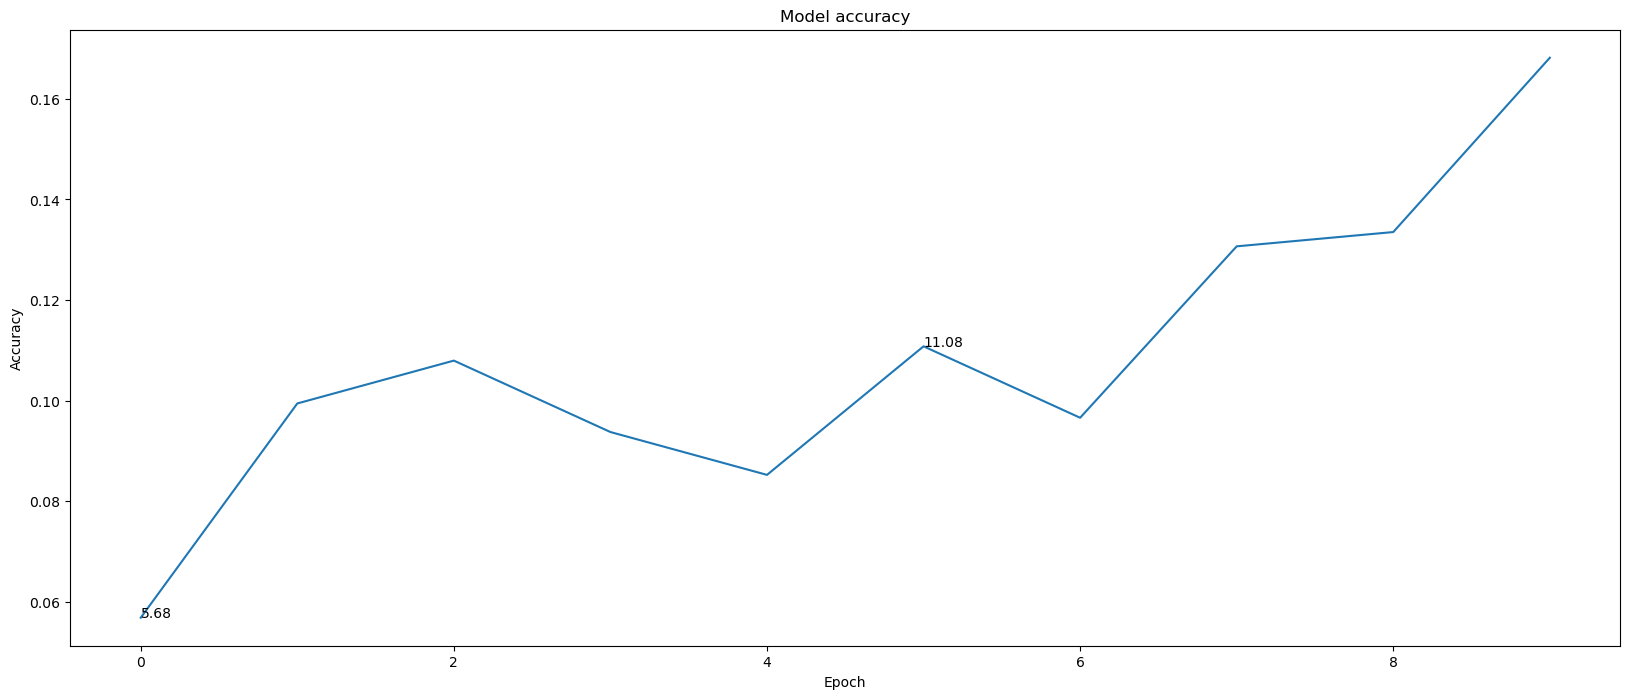

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

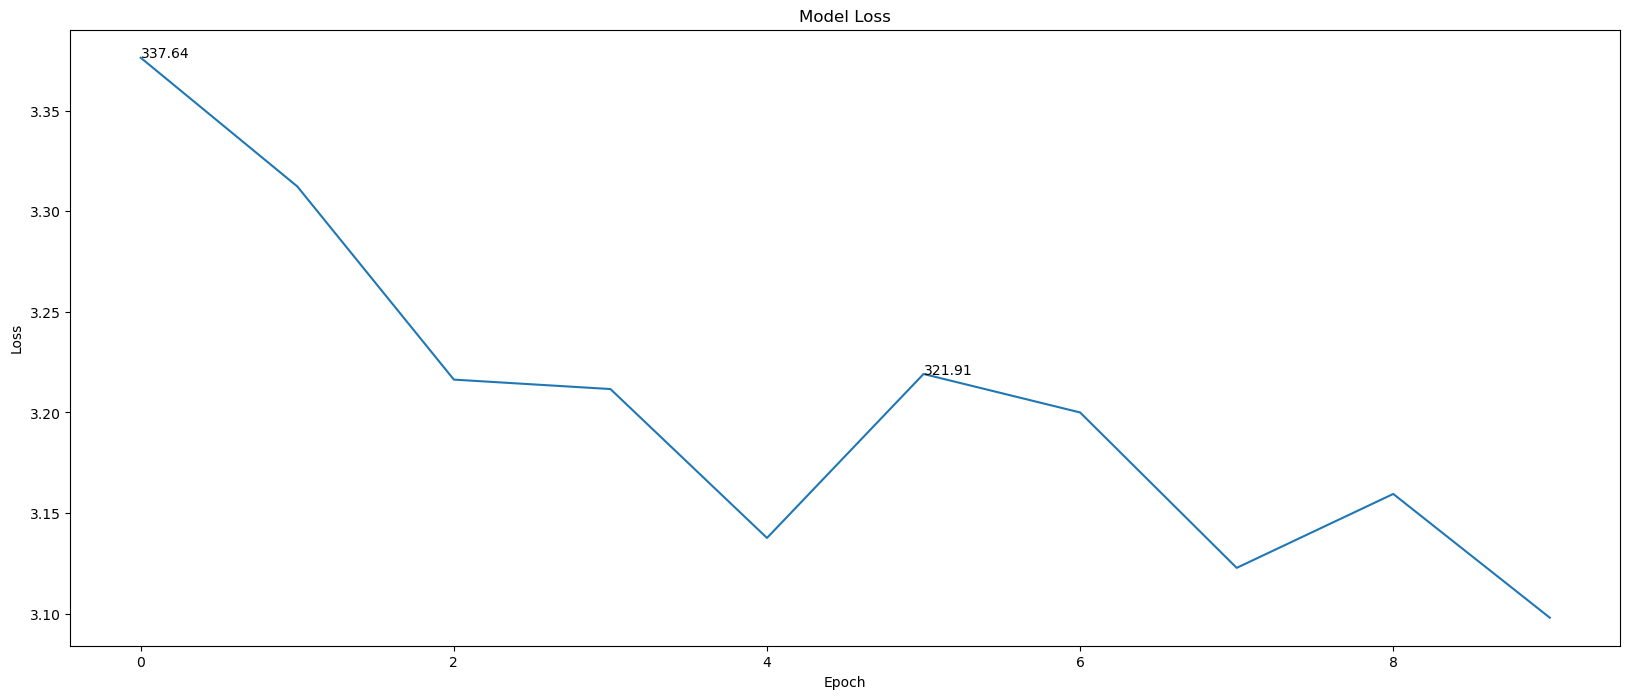

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()